In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                                              #importing libraries
import tensorflow as tf
import os
import cv2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Dense,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,MaxPooling2D,Reshape,Concatenate,LeakyReLU,Input,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import sigmoid

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')               #unzipping
zip_ref.extractall("/content/pix2pix_unzipped_folder")
zip_ref.close()

In [4]:
def load_data():
  real_A=[]
  path='/content/pix2pix_unzipped_folder/trainA'
  images=os.listdir(path)
  for image in images:
    Path=os.path.join(path,image)                                                           # loading the data
    img_cv2=cv2.imread(Path)
    img_cv2 = cv2.resize(img_cv2, (256,256))
    real_A.append(img_cv2)
  real_A=np.array(real_A)

  real_B=[]
  path='/content/pix2pix_unzipped_folder/trainB'
  images=os.listdir(path)
  for image in images:
    Path=os.path.join(path,image)
    img_cv2=cv2.imread(Path)
    img_cv2 = cv2.resize(img_cv2, (256,256))
    real_B.append(img_cv2)
  real_B=np.array(real_B)

  return real_B,real_A

In [5]:
real_A,real_B=load_data()

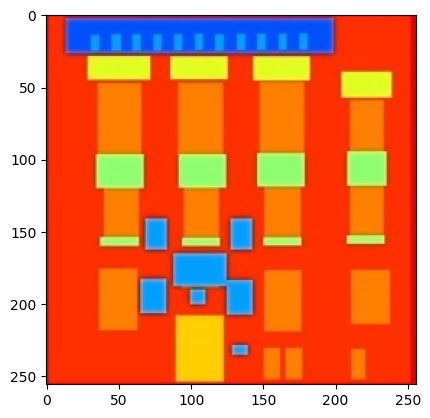

In [6]:
plt.imshow(real_A[7])

In [7]:
def define_discriminator(image_shape=(256,256,3)):

	# weight initialization
	init = RandomNormal(stddev=0.02)
	in_src_image = Input(shape=image_shape)
	in_target_image = Input(shape=image_shape)

	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])

	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
    #The model is trained with a batch size of one image and Adam opt.
    #with a small learning rate and 0.5 beta.
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [8]:
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g


In [9]:
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

In [10]:
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)

    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified
    out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
    # define model
    model = Model(in_image, out_image)
    return model


In [11]:
def define_gan(g_model, d_model, image_shape=(256,256,3)):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # define the source image
    in_src = Input(shape=image_shape)
    # supply the image as input to the generator
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and discriminator output as outputs
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model

In [12]:
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = np.random.randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [13]:
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = np.zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		plt.subplot(3, n_samples, 1 + n_samples*2 + i)
		plt.axis('off')
		plt.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


In [15]:
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	n_patch = d_model.output_shape[1]
	trainA, trainB = dataset
	bat_per_epo = int(len(trainA) / n_batch)
	n_steps = bat_per_epo * n_epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		summarize_performance(i, g_model, dataset)

In [16]:
d_model = define_discriminator()
g_model = define_generator()
# define the composite model
gan_model = define_gan(g_model, d_model)

#Define data
# load and prepare training images
data = load_data()

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime
start1 = datetime.now()

train(d_model, g_model, gan_model, dataset, n_epochs=1, n_batch=1)
stop1 = datetime.now()
#Execution time of the model
execution_time = stop1-start1
print("Execution time is: ", execution_time)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 1s 545ms/step
>1, d1[0.568] d2[2.732] g[46.547]
1/1 [==============================] - 0s 236ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_000001.png and model_000001.h5
1/1 [==============================] - 0s 89ms/step
>2, d1[0.845] d2[2.373] g[41.461]
1/1 [==============================] - 0s 253ms/step


>Saved: plot_000002.png and model_000002.h5
1/1 [==============================] - 0s 85ms/step
>3, d1[0.454] d2[1.319] g[37.115]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000003.png and model_000003.h5
1/1 [==============================] - 0s 88ms/step
>4, d1[0.492] d2[0.656] g[52.039]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000004.png and model_000004.h5
1/1 [==============================] - 0s 88ms/step
>5, d1[0.649] d2[0.551] g[45.606]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000005.png and model_000005.h5
1/1 [==============================] - 0s 88ms/step
>6, d1[0.576] d2[0.504] g[46.245]
1/1 [==============================] - 0s 235ms/step


>Saved: plot_000006.png and model_000006.h5
1/1 [==============================] - 0s 86ms/step
>7, d1[0.536] d2[0.481] g[36.512]
1/1 [==============================] - 0s 225ms/step


>Saved: plot_000007.png and model_000007.h5
1/1 [==============================] - 0s 88ms/step
>8, d1[0.546] d2[0.551] g[41.273]
1/1 [==============================] - 0s 235ms/step


>Saved: plot_000008.png and model_000008.h5
1/1 [==============================] - 0s 85ms/step
>9, d1[0.540] d2[0.509] g[48.912]
1/1 [==============================] - 0s 253ms/step


>Saved: plot_000009.png and model_000009.h5
1/1 [==============================] - 0s 85ms/step
>10, d1[0.510] d2[0.497] g[47.052]
1/1 [==============================] - 0s 230ms/step


>Saved: plot_000010.png and model_000010.h5
1/1 [==============================] - 0s 84ms/step
>11, d1[0.528] d2[0.485] g[40.559]
1/1 [==============================] - 0s 228ms/step


>Saved: plot_000011.png and model_000011.h5
1/1 [==============================] - 0s 87ms/step
>12, d1[0.512] d2[0.510] g[38.326]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000012.png and model_000012.h5
1/1 [==============================] - 0s 85ms/step
>13, d1[0.477] d2[0.494] g[41.103]
1/1 [==============================] - 0s 234ms/step


>Saved: plot_000013.png and model_000013.h5
1/1 [==============================] - 0s 85ms/step
>14, d1[0.522] d2[0.562] g[47.611]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000014.png and model_000014.h5
1/1 [==============================] - 0s 82ms/step
>15, d1[0.472] d2[0.485] g[41.002]
1/1 [==============================] - 0s 229ms/step


>Saved: plot_000015.png and model_000015.h5
1/1 [==============================] - 0s 88ms/step
>16, d1[0.543] d2[0.456] g[50.969]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000016.png and model_000016.h5
1/1 [==============================] - 0s 87ms/step
>17, d1[0.472] d2[0.575] g[25.949]
1/1 [==============================] - 0s 253ms/step


>Saved: plot_000017.png and model_000017.h5
1/1 [==============================] - 0s 92ms/step
>18, d1[0.536] d2[0.562] g[29.478]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000018.png and model_000018.h5
1/1 [==============================] - 0s 86ms/step
>19, d1[0.413] d2[0.476] g[41.522]
1/1 [==============================] - 0s 245ms/step


>Saved: plot_000019.png and model_000019.h5
1/1 [==============================] - 0s 84ms/step
>20, d1[0.456] d2[0.444] g[30.724]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000020.png and model_000020.h5
1/1 [==============================] - 0s 85ms/step
>21, d1[0.494] d2[0.518] g[53.614]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000021.png and model_000021.h5
1/1 [==============================] - 0s 87ms/step
>22, d1[0.479] d2[0.394] g[37.590]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000022.png and model_000022.h5
1/1 [==============================] - 0s 93ms/step
>23, d1[0.459] d2[0.483] g[34.377]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000023.png and model_000023.h5
1/1 [==============================] - 0s 91ms/step
>24, d1[0.360] d2[0.548] g[36.528]
1/1 [==============================] - 0s 220ms/step


>Saved: plot_000024.png and model_000024.h5
1/1 [==============================] - 0s 96ms/step
>25, d1[0.453] d2[0.444] g[41.941]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000025.png and model_000025.h5
1/1 [==============================] - 0s 87ms/step
>26, d1[0.470] d2[0.544] g[36.413]
1/1 [==============================] - 0s 230ms/step


>Saved: plot_000026.png and model_000026.h5
1/1 [==============================] - 0s 86ms/step
>27, d1[0.505] d2[0.437] g[48.169]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000027.png and model_000027.h5
1/1 [==============================] - 0s 84ms/step
>28, d1[0.463] d2[0.416] g[39.507]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000028.png and model_000028.h5
1/1 [==============================] - 0s 86ms/step
>29, d1[0.461] d2[0.506] g[31.881]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000029.png and model_000029.h5
1/1 [==============================] - 0s 85ms/step
>30, d1[0.464] d2[0.467] g[36.405]
1/1 [==============================] - 0s 232ms/step


>Saved: plot_000030.png and model_000030.h5
1/1 [==============================] - 0s 92ms/step
>31, d1[0.495] d2[0.462] g[34.038]
1/1 [==============================] - 0s 233ms/step


>Saved: plot_000031.png and model_000031.h5
1/1 [==============================] - 0s 82ms/step
>32, d1[0.447] d2[0.519] g[35.872]
1/1 [==============================] - 0s 206ms/step


>Saved: plot_000032.png and model_000032.h5
1/1 [==============================] - 0s 84ms/step
>33, d1[0.463] d2[0.511] g[48.792]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000033.png and model_000033.h5
1/1 [==============================] - 0s 87ms/step
>34, d1[0.478] d2[0.441] g[40.994]
1/1 [==============================] - 0s 225ms/step


>Saved: plot_000034.png and model_000034.h5
1/1 [==============================] - 0s 84ms/step
>35, d1[0.531] d2[0.494] g[35.107]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000035.png and model_000035.h5
1/1 [==============================] - 0s 87ms/step
>36, d1[0.464] d2[0.508] g[25.200]
1/1 [==============================] - 0s 229ms/step


>Saved: plot_000036.png and model_000036.h5
1/1 [==============================] - 0s 87ms/step
>37, d1[0.449] d2[0.368] g[31.353]
1/1 [==============================] - 0s 207ms/step


>Saved: plot_000037.png and model_000037.h5
1/1 [==============================] - 0s 81ms/step
>38, d1[0.471] d2[0.403] g[35.916]
1/1 [==============================] - 0s 197ms/step


>Saved: plot_000038.png and model_000038.h5
1/1 [==============================] - 0s 85ms/step
>39, d1[0.422] d2[0.468] g[40.742]
1/1 [==============================] - 0s 199ms/step


>Saved: plot_000039.png and model_000039.h5
1/1 [==============================] - 0s 85ms/step
>40, d1[0.454] d2[0.586] g[38.245]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000040.png and model_000040.h5
1/1 [==============================] - 0s 85ms/step
>41, d1[0.429] d2[0.400] g[47.936]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000041.png and model_000041.h5
1/1 [==============================] - 0s 86ms/step
>42, d1[0.442] d2[0.497] g[33.367]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000042.png and model_000042.h5
1/1 [==============================] - 0s 85ms/step
>43, d1[0.422] d2[0.505] g[60.581]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000043.png and model_000043.h5
1/1 [==============================] - 0s 86ms/step
>44, d1[0.497] d2[0.412] g[35.687]
1/1 [==============================] - 0s 230ms/step


>Saved: plot_000044.png and model_000044.h5
1/1 [==============================] - 0s 85ms/step
>45, d1[0.430] d2[0.397] g[37.366]
1/1 [==============================] - 0s 227ms/step


>Saved: plot_000045.png and model_000045.h5
1/1 [==============================] - 0s 83ms/step
>46, d1[0.457] d2[0.525] g[44.231]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000046.png and model_000046.h5
1/1 [==============================] - 0s 84ms/step
>47, d1[0.392] d2[0.465] g[46.286]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000047.png and model_000047.h5
1/1 [==============================] - 0s 84ms/step
>48, d1[0.461] d2[0.445] g[41.201]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000048.png and model_000048.h5
1/1 [==============================] - 0s 87ms/step
>49, d1[0.388] d2[0.600] g[28.370]
1/1 [==============================] - 0s 203ms/step


>Saved: plot_000049.png and model_000049.h5
1/1 [==============================] - 0s 88ms/step
>50, d1[0.539] d2[0.361] g[34.272]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000050.png and model_000050.h5
1/1 [==============================] - 0s 83ms/step
>51, d1[0.520] d2[0.431] g[24.637]
1/1 [==============================] - 0s 228ms/step


>Saved: plot_000051.png and model_000051.h5
1/1 [==============================] - 0s 91ms/step
>52, d1[0.459] d2[0.432] g[33.405]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000052.png and model_000052.h5
1/1 [==============================] - 0s 81ms/step
>53, d1[0.401] d2[0.426] g[37.125]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000053.png and model_000053.h5
1/1 [==============================] - 0s 84ms/step
>54, d1[0.353] d2[0.615] g[27.711]
1/1 [==============================] - 0s 207ms/step


>Saved: plot_000054.png and model_000054.h5
1/1 [==============================] - 0s 81ms/step
>55, d1[0.467] d2[0.332] g[42.657]
1/1 [==============================] - 0s 208ms/step


>Saved: plot_000055.png and model_000055.h5
1/1 [==============================] - 0s 84ms/step
>56, d1[0.448] d2[0.491] g[38.703]
1/1 [==============================] - 0s 223ms/step


>Saved: plot_000056.png and model_000056.h5
1/1 [==============================] - 0s 82ms/step
>57, d1[0.428] d2[0.442] g[29.934]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000057.png and model_000057.h5
1/1 [==============================] - 0s 85ms/step
>58, d1[0.397] d2[0.388] g[30.964]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000058.png and model_000058.h5
1/1 [==============================] - 0s 87ms/step
>59, d1[0.423] d2[0.417] g[23.413]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000059.png and model_000059.h5
1/1 [==============================] - 0s 83ms/step
>60, d1[0.420] d2[0.551] g[26.984]
1/1 [==============================] - 0s 220ms/step


>Saved: plot_000060.png and model_000060.h5
1/1 [==============================] - 0s 83ms/step
>61, d1[0.466] d2[0.415] g[41.279]
1/1 [==============================] - 0s 230ms/step


>Saved: plot_000061.png and model_000061.h5
1/1 [==============================] - 0s 90ms/step
>62, d1[0.420] d2[0.525] g[42.026]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000062.png and model_000062.h5
1/1 [==============================] - 0s 82ms/step
>63, d1[0.463] d2[0.373] g[55.677]
1/1 [==============================] - 0s 225ms/step


>Saved: plot_000063.png and model_000063.h5
1/1 [==============================] - 0s 84ms/step
>64, d1[0.383] d2[0.521] g[27.172]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000064.png and model_000064.h5
1/1 [==============================] - 0s 84ms/step
>65, d1[0.372] d2[0.437] g[33.335]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000065.png and model_000065.h5
1/1 [==============================] - 0s 86ms/step
>66, d1[0.371] d2[0.327] g[24.007]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000066.png and model_000066.h5
1/1 [==============================] - 0s 83ms/step
>67, d1[0.402] d2[0.353] g[47.394]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000067.png and model_000067.h5
1/1 [==============================] - 0s 83ms/step
>68, d1[0.326] d2[0.562] g[26.765]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000068.png and model_000068.h5
1/1 [==============================] - 0s 85ms/step
>69, d1[0.605] d2[0.426] g[58.226]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000069.png and model_000069.h5
1/1 [==============================] - 0s 86ms/step
>70, d1[0.466] d2[0.340] g[48.759]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000070.png and model_000070.h5
1/1 [==============================] - 0s 85ms/step
>71, d1[0.396] d2[0.399] g[36.785]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000071.png and model_000071.h5
1/1 [==============================] - 0s 83ms/step
>72, d1[0.430] d2[0.407] g[30.732]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000072.png and model_000072.h5
1/1 [==============================] - 0s 85ms/step
>73, d1[0.401] d2[0.555] g[39.917]
1/1 [==============================] - 0s 202ms/step


>Saved: plot_000073.png and model_000073.h5
1/1 [==============================] - 0s 85ms/step
>74, d1[0.434] d2[0.407] g[37.545]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000074.png and model_000074.h5
1/1 [==============================] - 0s 86ms/step
>75, d1[0.440] d2[0.521] g[42.214]
1/1 [==============================] - 0s 210ms/step


>Saved: plot_000075.png and model_000075.h5
1/1 [==============================] - 0s 88ms/step
>76, d1[0.292] d2[0.287] g[43.063]
1/1 [==============================] - 0s 231ms/step


>Saved: plot_000076.png and model_000076.h5
1/1 [==============================] - 0s 86ms/step
>77, d1[0.382] d2[0.295] g[37.159]
1/1 [==============================] - 0s 223ms/step


>Saved: plot_000077.png and model_000077.h5
1/1 [==============================] - 0s 86ms/step
>78, d1[0.379] d2[0.266] g[39.713]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000078.png and model_000078.h5
1/1 [==============================] - 0s 86ms/step
>79, d1[0.224] d2[0.330] g[48.798]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000079.png and model_000079.h5
1/1 [==============================] - 0s 88ms/step
>80, d1[0.683] d2[0.359] g[36.645]
1/1 [==============================] - 0s 240ms/step


>Saved: plot_000080.png and model_000080.h5
1/1 [==============================] - 0s 88ms/step
>81, d1[0.214] d2[0.413] g[54.631]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000081.png and model_000081.h5
1/1 [==============================] - 0s 86ms/step
>82, d1[0.158] d2[0.254] g[42.809]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000082.png and model_000082.h5
1/1 [==============================] - 0s 89ms/step
>83, d1[0.314] d2[0.167] g[38.045]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000083.png and model_000083.h5
1/1 [==============================] - 0s 87ms/step
>84, d1[0.302] d2[0.332] g[44.935]
1/1 [==============================] - 0s 229ms/step


>Saved: plot_000084.png and model_000084.h5
1/1 [==============================] - 0s 96ms/step
>85, d1[0.144] d2[0.229] g[38.431]
1/1 [==============================] - 0s 227ms/step


>Saved: plot_000085.png and model_000085.h5
1/1 [==============================] - 0s 85ms/step
>86, d1[0.667] d2[0.307] g[35.544]
1/1 [==============================] - 0s 220ms/step


>Saved: plot_000086.png and model_000086.h5
1/1 [==============================] - 0s 87ms/step
>87, d1[0.136] d2[0.278] g[38.230]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000087.png and model_000087.h5
1/1 [==============================] - 0s 88ms/step
>88, d1[0.125] d2[0.183] g[64.295]
1/1 [==============================] - 0s 236ms/step


>Saved: plot_000088.png and model_000088.h5
1/1 [==============================] - 0s 95ms/step
>89, d1[0.213] d2[0.333] g[36.803]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000089.png and model_000089.h5
1/1 [==============================] - 0s 82ms/step
>90, d1[0.238] d2[0.184] g[48.858]
1/1 [==============================] - 0s 210ms/step


>Saved: plot_000090.png and model_000090.h5
1/1 [==============================] - 0s 86ms/step
>91, d1[0.357] d2[0.391] g[34.758]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000091.png and model_000091.h5
1/1 [==============================] - 0s 88ms/step
>92, d1[0.429] d2[0.265] g[39.286]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000092.png and model_000092.h5
1/1 [==============================] - 0s 91ms/step
>93, d1[0.255] d2[0.329] g[61.434]
1/1 [==============================] - 0s 258ms/step


>Saved: plot_000093.png and model_000093.h5
1/1 [==============================] - 0s 95ms/step
>94, d1[0.660] d2[0.330] g[31.951]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000094.png and model_000094.h5
1/1 [==============================] - 0s 86ms/step
>95, d1[0.436] d2[1.011] g[33.785]
1/1 [==============================] - 0s 231ms/step


>Saved: plot_000095.png and model_000095.h5
1/1 [==============================] - 0s 89ms/step
>96, d1[0.310] d2[0.381] g[32.120]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000096.png and model_000096.h5
1/1 [==============================] - 0s 89ms/step
>97, d1[0.391] d2[0.272] g[49.189]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000097.png and model_000097.h5
1/1 [==============================] - 0s 89ms/step
>98, d1[0.267] d2[0.394] g[41.629]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000098.png and model_000098.h5
1/1 [==============================] - 0s 85ms/step
>99, d1[0.611] d2[0.120] g[34.362]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000099.png and model_000099.h5
1/1 [==============================] - 0s 83ms/step
>100, d1[0.350] d2[0.243] g[43.088]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000100.png and model_000100.h5
1/1 [==============================] - 0s 84ms/step
>101, d1[0.047] d2[0.278] g[32.953]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000101.png and model_000101.h5
1/1 [==============================] - 0s 84ms/step
>102, d1[0.461] d2[0.207] g[30.413]
1/1 [==============================] - 0s 223ms/step


>Saved: plot_000102.png and model_000102.h5
1/1 [==============================] - 0s 87ms/step
>103, d1[0.412] d2[0.332] g[33.853]
1/1 [==============================] - 0s 210ms/step


>Saved: plot_000103.png and model_000103.h5
1/1 [==============================] - 0s 86ms/step
>104, d1[0.195] d2[0.285] g[33.958]
1/1 [==============================] - 0s 231ms/step


>Saved: plot_000104.png and model_000104.h5
1/1 [==============================] - 0s 89ms/step
>105, d1[0.131] d2[0.159] g[43.010]
1/1 [==============================] - 0s 239ms/step


>Saved: plot_000105.png and model_000105.h5
1/1 [==============================] - 0s 89ms/step
>106, d1[0.147] d2[0.131] g[40.974]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000106.png and model_000106.h5
1/1 [==============================] - 0s 90ms/step
>107, d1[0.097] d2[0.086] g[44.004]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000107.png and model_000107.h5
1/1 [==============================] - 0s 90ms/step
>108, d1[0.449] d2[0.197] g[33.965]
1/1 [==============================] - 0s 233ms/step


>Saved: plot_000108.png and model_000108.h5
1/1 [==============================] - 0s 85ms/step
>109, d1[0.143] d2[0.139] g[41.833]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000109.png and model_000109.h5
1/1 [==============================] - 0s 88ms/step
>110, d1[0.341] d2[0.183] g[38.671]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000110.png and model_000110.h5
1/1 [==============================] - 0s 87ms/step
>111, d1[0.115] d2[0.233] g[41.313]
1/1 [==============================] - 0s 229ms/step


>Saved: plot_000111.png and model_000111.h5
1/1 [==============================] - 0s 82ms/step
>112, d1[0.034] d2[0.447] g[48.022]
1/1 [==============================] - 0s 227ms/step


>Saved: plot_000112.png and model_000112.h5
1/1 [==============================] - 0s 85ms/step
>113, d1[0.051] d2[0.120] g[35.655]
1/1 [==============================] - 0s 208ms/step


>Saved: plot_000113.png and model_000113.h5
1/1 [==============================] - 0s 83ms/step
>114, d1[0.420] d2[0.047] g[52.999]
1/1 [==============================] - 0s 195ms/step


>Saved: plot_000114.png and model_000114.h5
1/1 [==============================] - 0s 83ms/step
>115, d1[0.146] d2[0.101] g[28.905]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000115.png and model_000115.h5
1/1 [==============================] - 0s 86ms/step
>116, d1[0.102] d2[0.094] g[39.468]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000116.png and model_000116.h5
1/1 [==============================] - 0s 85ms/step
>117, d1[0.028] d2[0.062] g[49.574]
1/1 [==============================] - 0s 207ms/step


>Saved: plot_000117.png and model_000117.h5
1/1 [==============================] - 0s 84ms/step
>118, d1[0.073] d2[0.192] g[40.912]
1/1 [==============================] - 0s 225ms/step


>Saved: plot_000118.png and model_000118.h5
1/1 [==============================] - 0s 89ms/step
>119, d1[0.450] d2[0.050] g[46.974]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000119.png and model_000119.h5
1/1 [==============================] - 0s 85ms/step
>120, d1[0.037] d2[0.146] g[37.844]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000120.png and model_000120.h5
1/1 [==============================] - 0s 88ms/step
>121, d1[0.188] d2[0.068] g[33.683]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000121.png and model_000121.h5
1/1 [==============================] - 0s 84ms/step
>122, d1[0.266] d2[0.129] g[43.926]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000122.png and model_000122.h5
1/1 [==============================] - 0s 87ms/step
>123, d1[0.086] d2[0.107] g[33.850]
1/1 [==============================] - 0s 249ms/step


>Saved: plot_000123.png and model_000123.h5
1/1 [==============================] - 0s 86ms/step
>124, d1[0.011] d2[0.053] g[40.997]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000124.png and model_000124.h5
1/1 [==============================] - 0s 86ms/step
>125, d1[0.020] d2[0.065] g[36.086]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000125.png and model_000125.h5
1/1 [==============================] - 0s 86ms/step
>126, d1[0.156] d2[0.041] g[46.488]
1/1 [==============================] - 0s 210ms/step


>Saved: plot_000126.png and model_000126.h5
1/1 [==============================] - 0s 86ms/step
>127, d1[0.101] d2[0.072] g[43.303]
1/1 [==============================] - 0s 243ms/step


>Saved: plot_000127.png and model_000127.h5
1/1 [==============================] - 0s 86ms/step
>128, d1[0.417] d2[0.455] g[38.340]
1/1 [==============================] - 0s 251ms/step


>Saved: plot_000128.png and model_000128.h5
1/1 [==============================] - 0s 87ms/step
>129, d1[0.045] d2[0.597] g[28.711]
1/1 [==============================] - 0s 201ms/step


>Saved: plot_000129.png and model_000129.h5
1/1 [==============================] - 0s 85ms/step
>130, d1[0.140] d2[0.310] g[33.666]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000130.png and model_000130.h5
1/1 [==============================] - 0s 86ms/step
>131, d1[0.095] d2[0.036] g[58.008]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000131.png and model_000131.h5
1/1 [==============================] - 0s 89ms/step
>132, d1[0.315] d2[0.036] g[31.557]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000132.png and model_000132.h5
1/1 [==============================] - 0s 85ms/step
>133, d1[0.119] d2[0.069] g[30.812]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000133.png and model_000133.h5
1/1 [==============================] - 0s 86ms/step
>134, d1[0.014] d2[0.069] g[37.093]
1/1 [==============================] - 0s 231ms/step


>Saved: plot_000134.png and model_000134.h5
1/1 [==============================] - 0s 93ms/step
>135, d1[0.024] d2[0.047] g[40.657]
1/1 [==============================] - 0s 206ms/step


>Saved: plot_000135.png and model_000135.h5
1/1 [==============================] - 0s 90ms/step
>136, d1[0.459] d2[0.311] g[31.888]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000136.png and model_000136.h5
1/1 [==============================] - 0s 85ms/step
>137, d1[0.055] d2[0.209] g[35.440]
1/1 [==============================] - 0s 220ms/step


>Saved: plot_000137.png and model_000137.h5
1/1 [==============================] - 0s 83ms/step
>138, d1[0.021] d2[0.060] g[36.588]
1/1 [==============================] - 0s 223ms/step


>Saved: plot_000138.png and model_000138.h5
1/1 [==============================] - 0s 86ms/step
>139, d1[0.088] d2[0.066] g[36.087]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000139.png and model_000139.h5
1/1 [==============================] - 0s 86ms/step
>140, d1[0.040] d2[0.041] g[42.461]
1/1 [==============================] - 0s 227ms/step


>Saved: plot_000140.png and model_000140.h5
1/1 [==============================] - 0s 85ms/step
>141, d1[0.018] d2[0.018] g[42.035]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000141.png and model_000141.h5
1/1 [==============================] - 0s 90ms/step
>142, d1[0.153] d2[0.043] g[42.488]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000142.png and model_000142.h5
1/1 [==============================] - 0s 90ms/step
>143, d1[0.011] d2[0.034] g[32.674]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000143.png and model_000143.h5
1/1 [==============================] - 0s 85ms/step
>144, d1[0.016] d2[0.058] g[29.183]
1/1 [==============================] - 0s 235ms/step


>Saved: plot_000144.png and model_000144.h5
1/1 [==============================] - 0s 87ms/step
>145, d1[0.027] d2[0.013] g[35.965]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000145.png and model_000145.h5
1/1 [==============================] - 0s 84ms/step
>146, d1[0.047] d2[0.024] g[44.251]
1/1 [==============================] - 0s 231ms/step


>Saved: plot_000146.png and model_000146.h5
1/1 [==============================] - 0s 82ms/step
>147, d1[0.071] d2[0.043] g[46.566]
1/1 [==============================] - 0s 220ms/step


>Saved: plot_000147.png and model_000147.h5
1/1 [==============================] - 0s 82ms/step
>148, d1[0.020] d2[0.020] g[25.816]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000148.png and model_000148.h5
1/1 [==============================] - 0s 85ms/step
>149, d1[0.038] d2[0.020] g[35.170]
1/1 [==============================] - 0s 226ms/step


>Saved: plot_000149.png and model_000149.h5
1/1 [==============================] - 0s 86ms/step
>150, d1[0.006] d2[0.015] g[41.584]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000150.png and model_000150.h5
1/1 [==============================] - 0s 86ms/step
>151, d1[0.012] d2[0.019] g[35.413]
1/1 [==============================] - 0s 227ms/step


>Saved: plot_000151.png and model_000151.h5
1/1 [==============================] - 0s 86ms/step
>152, d1[0.055] d2[0.015] g[43.289]
1/1 [==============================] - 0s 233ms/step


>Saved: plot_000152.png and model_000152.h5
1/1 [==============================] - 0s 87ms/step
>153, d1[0.110] d2[0.382] g[49.565]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000153.png and model_000153.h5
1/1 [==============================] - 0s 86ms/step
>154, d1[0.905] d2[1.236] g[28.884]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000154.png and model_000154.h5
1/1 [==============================] - 0s 86ms/step
>155, d1[0.424] d2[0.913] g[46.618]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000155.png and model_000155.h5
1/1 [==============================] - 0s 85ms/step
>156, d1[0.163] d2[0.098] g[52.540]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000156.png and model_000156.h5
1/1 [==============================] - 0s 87ms/step
>157, d1[0.209] d2[0.763] g[37.276]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000157.png and model_000157.h5
1/1 [==============================] - 0s 87ms/step
>158, d1[1.222] d2[0.511] g[34.997]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000158.png and model_000158.h5
1/1 [==============================] - 0s 91ms/step
>159, d1[0.413] d2[0.510] g[36.156]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000159.png and model_000159.h5
1/1 [==============================] - 0s 84ms/step
>160, d1[1.270] d2[0.200] g[33.812]
1/1 [==============================] - 0s 227ms/step


>Saved: plot_000160.png and model_000160.h5
1/1 [==============================] - 0s 88ms/step
>161, d1[0.151] d2[0.517] g[43.431]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000161.png and model_000161.h5
1/1 [==============================] - 0s 86ms/step
>162, d1[0.704] d2[0.355] g[39.936]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000162.png and model_000162.h5
1/1 [==============================] - 0s 86ms/step
>163, d1[0.252] d2[0.348] g[54.799]
1/1 [==============================] - 0s 231ms/step


>Saved: plot_000163.png and model_000163.h5
1/1 [==============================] - 0s 83ms/step
>164, d1[0.383] d2[0.210] g[37.546]
1/1 [==============================] - 0s 251ms/step


>Saved: plot_000164.png and model_000164.h5
1/1 [==============================] - 0s 96ms/step
>165, d1[0.535] d2[0.605] g[45.709]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000165.png and model_000165.h5
1/1 [==============================] - 0s 82ms/step
>166, d1[0.293] d2[0.258] g[47.540]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000166.png and model_000166.h5
1/1 [==============================] - 0s 83ms/step
>167, d1[0.678] d2[0.476] g[30.143]
1/1 [==============================] - 0s 228ms/step


>Saved: plot_000167.png and model_000167.h5
1/1 [==============================] - 0s 89ms/step
>168, d1[0.173] d2[1.034] g[45.553]
1/1 [==============================] - 0s 210ms/step


>Saved: plot_000168.png and model_000168.h5
1/1 [==============================] - 0s 87ms/step
>169, d1[0.851] d2[0.110] g[39.470]
1/1 [==============================] - 0s 223ms/step


>Saved: plot_000169.png and model_000169.h5
1/1 [==============================] - 0s 87ms/step
>170, d1[0.380] d2[0.442] g[32.974]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000170.png and model_000170.h5
1/1 [==============================] - 0s 84ms/step
>171, d1[0.218] d2[0.350] g[36.032]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000171.png and model_000171.h5
1/1 [==============================] - 0s 87ms/step
>172, d1[0.511] d2[0.259] g[33.267]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000172.png and model_000172.h5
1/1 [==============================] - 0s 88ms/step
>173, d1[0.290] d2[0.261] g[46.712]
1/1 [==============================] - 0s 230ms/step


>Saved: plot_000173.png and model_000173.h5
1/1 [==============================] - 0s 88ms/step
>174, d1[0.095] d2[0.101] g[34.257]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000174.png and model_000174.h5
1/1 [==============================] - 0s 88ms/step
>175, d1[0.390] d2[0.404] g[40.261]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000175.png and model_000175.h5
1/1 [==============================] - 0s 87ms/step
>176, d1[0.388] d2[0.906] g[42.974]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000176.png and model_000176.h5
1/1 [==============================] - 0s 83ms/step
>177, d1[0.423] d2[0.299] g[31.578]
1/1 [==============================] - 0s 247ms/step


>Saved: plot_000177.png and model_000177.h5
1/1 [==============================] - 0s 84ms/step
>178, d1[0.262] d2[0.129] g[38.509]
1/1 [==============================] - 0s 248ms/step


>Saved: plot_000178.png and model_000178.h5
1/1 [==============================] - 0s 84ms/step
>179, d1[0.209] d2[0.161] g[37.723]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000179.png and model_000179.h5
1/1 [==============================] - 0s 86ms/step
>180, d1[0.121] d2[0.128] g[41.719]
1/1 [==============================] - 0s 228ms/step


>Saved: plot_000180.png and model_000180.h5
1/1 [==============================] - 0s 84ms/step
>181, d1[0.159] d2[0.346] g[42.009]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000181.png and model_000181.h5
1/1 [==============================] - 0s 86ms/step
>182, d1[0.225] d2[0.195] g[38.754]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000182.png and model_000182.h5
1/1 [==============================] - 0s 85ms/step
>183, d1[0.362] d2[0.142] g[35.186]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000183.png and model_000183.h5
1/1 [==============================] - 0s 88ms/step
>184, d1[0.463] d2[0.191] g[33.441]
1/1 [==============================] - 0s 237ms/step


>Saved: plot_000184.png and model_000184.h5
1/1 [==============================] - 0s 86ms/step
>185, d1[0.029] d2[0.139] g[43.509]
1/1 [==============================] - 0s 262ms/step


>Saved: plot_000185.png and model_000185.h5
1/1 [==============================] - 0s 91ms/step
>186, d1[0.088] d2[0.092] g[46.763]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000186.png and model_000186.h5
1/1 [==============================] - 0s 88ms/step
>187, d1[0.033] d2[0.088] g[40.647]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000187.png and model_000187.h5
1/1 [==============================] - 0s 86ms/step
>188, d1[0.385] d2[0.359] g[46.386]
1/1 [==============================] - 0s 210ms/step


>Saved: plot_000188.png and model_000188.h5
1/1 [==============================] - 0s 88ms/step
>189, d1[0.123] d2[0.310] g[36.027]
1/1 [==============================] - 0s 238ms/step


>Saved: plot_000189.png and model_000189.h5
1/1 [==============================] - 0s 86ms/step
>190, d1[0.157] d2[0.046] g[45.663]
1/1 [==============================] - 0s 225ms/step


>Saved: plot_000190.png and model_000190.h5
1/1 [==============================] - 0s 88ms/step
>191, d1[0.063] d2[0.142] g[36.923]
1/1 [==============================] - 0s 256ms/step


>Saved: plot_000191.png and model_000191.h5
1/1 [==============================] - 0s 89ms/step
>192, d1[0.053] d2[0.050] g[31.465]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000192.png and model_000192.h5
1/1 [==============================] - 0s 82ms/step
>193, d1[0.091] d2[0.051] g[39.632]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000193.png and model_000193.h5
1/1 [==============================] - 0s 84ms/step
>194, d1[0.019] d2[0.075] g[37.009]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000194.png and model_000194.h5
1/1 [==============================] - 0s 88ms/step
>195, d1[0.033] d2[0.075] g[33.167]
1/1 [==============================] - 0s 235ms/step


>Saved: plot_000195.png and model_000195.h5
1/1 [==============================] - 0s 85ms/step
>196, d1[0.117] d2[0.046] g[35.013]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000196.png and model_000196.h5
1/1 [==============================] - 0s 89ms/step
>197, d1[0.204] d2[0.245] g[49.568]
1/1 [==============================] - 0s 235ms/step


>Saved: plot_000197.png and model_000197.h5
1/1 [==============================] - 0s 94ms/step
>198, d1[0.433] d2[0.186] g[39.562]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000198.png and model_000198.h5
1/1 [==============================] - 0s 83ms/step
>199, d1[0.100] d2[0.207] g[33.794]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000199.png and model_000199.h5
1/1 [==============================] - 0s 85ms/step
>200, d1[0.072] d2[0.236] g[38.823]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000200.png and model_000200.h5
1/1 [==============================] - 0s 90ms/step
>201, d1[0.497] d2[0.966] g[29.332]
1/1 [==============================] - 0s 224ms/step


>Saved: plot_000201.png and model_000201.h5
1/1 [==============================] - 0s 96ms/step
>202, d1[0.142] d2[0.141] g[33.956]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000202.png and model_000202.h5
1/1 [==============================] - 0s 85ms/step
>203, d1[0.258] d2[0.152] g[34.482]
1/1 [==============================] - 0s 227ms/step


>Saved: plot_000203.png and model_000203.h5
1/1 [==============================] - 0s 83ms/step
>204, d1[0.025] d2[0.060] g[35.027]
1/1 [==============================] - 0s 207ms/step


>Saved: plot_000204.png and model_000204.h5
1/1 [==============================] - 0s 98ms/step
>205, d1[0.609] d2[0.160] g[40.759]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000205.png and model_000205.h5
1/1 [==============================] - 0s 88ms/step
>206, d1[0.015] d2[0.692] g[34.520]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000206.png and model_000206.h5
1/1 [==============================] - 0s 93ms/step
>207, d1[0.194] d2[0.030] g[40.286]
1/1 [==============================] - 0s 223ms/step


>Saved: plot_000207.png and model_000207.h5
1/1 [==============================] - 0s 94ms/step
>208, d1[0.591] d2[0.131] g[40.292]
1/1 [==============================] - 0s 238ms/step


>Saved: plot_000208.png and model_000208.h5
1/1 [==============================] - 0s 91ms/step
>209, d1[0.092] d2[0.098] g[43.944]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000209.png and model_000209.h5
1/1 [==============================] - 0s 85ms/step
>210, d1[0.363] d2[0.137] g[25.846]
1/1 [==============================] - 0s 231ms/step


>Saved: plot_000210.png and model_000210.h5
1/1 [==============================] - 0s 89ms/step
>211, d1[0.011] d2[0.091] g[32.437]
1/1 [==============================] - 0s 220ms/step


>Saved: plot_000211.png and model_000211.h5
1/1 [==============================] - 0s 87ms/step
>212, d1[0.016] d2[0.044] g[37.992]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000212.png and model_000212.h5
1/1 [==============================] - 0s 89ms/step
>213, d1[0.014] d2[0.022] g[27.532]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000213.png and model_000213.h5
1/1 [==============================] - 0s 89ms/step
>214, d1[0.306] d2[0.076] g[30.591]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000214.png and model_000214.h5
1/1 [==============================] - 0s 94ms/step
>215, d1[0.005] d2[0.091] g[40.949]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000215.png and model_000215.h5
1/1 [==============================] - 0s 87ms/step
>216, d1[0.008] d2[0.226] g[41.565]
1/1 [==============================] - 0s 248ms/step


>Saved: plot_000216.png and model_000216.h5
1/1 [==============================] - 0s 84ms/step
>217, d1[0.009] d2[0.021] g[40.640]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000217.png and model_000217.h5
1/1 [==============================] - 0s 84ms/step
>218, d1[0.048] d2[0.015] g[31.666]
1/1 [==============================] - 0s 242ms/step


>Saved: plot_000218.png and model_000218.h5
1/1 [==============================] - 0s 95ms/step
>219, d1[0.112] d2[0.145] g[37.369]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000219.png and model_000219.h5
1/1 [==============================] - 0s 84ms/step
>220, d1[0.159] d2[0.024] g[41.104]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000220.png and model_000220.h5
1/1 [==============================] - 0s 87ms/step
>221, d1[0.112] d2[0.035] g[32.503]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000221.png and model_000221.h5
1/1 [==============================] - 0s 81ms/step
>222, d1[0.014] d2[0.058] g[35.997]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000222.png and model_000222.h5
1/1 [==============================] - 0s 93ms/step
>223, d1[0.163] d2[0.050] g[39.091]
1/1 [==============================] - 0s 240ms/step


>Saved: plot_000223.png and model_000223.h5
1/1 [==============================] - 0s 84ms/step
>224, d1[0.038] d2[0.023] g[37.879]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000224.png and model_000224.h5
1/1 [==============================] - 0s 86ms/step
>225, d1[0.049] d2[0.497] g[34.011]
1/1 [==============================] - 0s 208ms/step


>Saved: plot_000225.png and model_000225.h5
1/1 [==============================] - 0s 85ms/step
>226, d1[0.467] d2[0.109] g[26.032]
1/1 [==============================] - 0s 223ms/step


>Saved: plot_000226.png and model_000226.h5
1/1 [==============================] - 0s 85ms/step
>227, d1[0.153] d2[0.098] g[28.652]
1/1 [==============================] - 0s 204ms/step


>Saved: plot_000227.png and model_000227.h5
1/1 [==============================] - 0s 86ms/step
>228, d1[0.006] d2[0.035] g[33.757]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000228.png and model_000228.h5
1/1 [==============================] - 0s 83ms/step
>229, d1[0.020] d2[0.084] g[43.360]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000229.png and model_000229.h5
1/1 [==============================] - 0s 86ms/step
>230, d1[0.089] d2[0.017] g[28.810]
1/1 [==============================] - 0s 249ms/step


>Saved: plot_000230.png and model_000230.h5
1/1 [==============================] - 0s 85ms/step
>231, d1[0.052] d2[0.371] g[33.897]
1/1 [==============================] - 0s 203ms/step


>Saved: plot_000231.png and model_000231.h5
1/1 [==============================] - 0s 84ms/step
>232, d1[0.128] d2[0.029] g[28.546]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000232.png and model_000232.h5
1/1 [==============================] - 0s 86ms/step
>233, d1[0.066] d2[0.068] g[57.368]
1/1 [==============================] - 0s 232ms/step


>Saved: plot_000233.png and model_000233.h5
1/1 [==============================] - 0s 84ms/step
>234, d1[0.053] d2[0.017] g[52.945]
1/1 [==============================] - 0s 210ms/step


>Saved: plot_000234.png and model_000234.h5
1/1 [==============================] - 0s 86ms/step
>235, d1[0.137] d2[0.020] g[47.995]
1/1 [==============================] - 0s 234ms/step


>Saved: plot_000235.png and model_000235.h5
1/1 [==============================] - 0s 102ms/step
>236, d1[0.046] d2[0.017] g[39.507]
1/1 [==============================] - 0s 203ms/step


>Saved: plot_000236.png and model_000236.h5
1/1 [==============================] - 0s 87ms/step
>237, d1[0.071] d2[0.015] g[49.624]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000237.png and model_000237.h5
1/1 [==============================] - 0s 85ms/step
>238, d1[0.030] d2[0.027] g[41.215]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000238.png and model_000238.h5
1/1 [==============================] - 0s 87ms/step
>239, d1[0.040] d2[0.021] g[23.972]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000239.png and model_000239.h5
1/1 [==============================] - 0s 88ms/step
>240, d1[0.007] d2[0.022] g[27.398]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000240.png and model_000240.h5
1/1 [==============================] - 0s 82ms/step
>241, d1[0.036] d2[0.036] g[45.230]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000241.png and model_000241.h5
1/1 [==============================] - 0s 84ms/step
>242, d1[0.042] d2[0.022] g[35.384]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000242.png and model_000242.h5
1/1 [==============================] - 0s 85ms/step
>243, d1[0.563] d2[0.182] g[31.180]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000243.png and model_000243.h5
1/1 [==============================] - 0s 84ms/step
>244, d1[0.003] d2[0.664] g[39.560]
1/1 [==============================] - 0s 220ms/step


>Saved: plot_000244.png and model_000244.h5
1/1 [==============================] - 0s 84ms/step
>245, d1[0.004] d2[0.190] g[43.075]
1/1 [==============================] - 0s 246ms/step


>Saved: plot_000245.png and model_000245.h5
1/1 [==============================] - 0s 86ms/step
>246, d1[0.290] d2[0.055] g[35.094]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000246.png and model_000246.h5
1/1 [==============================] - 0s 83ms/step
>247, d1[0.017] d2[0.039] g[30.783]
1/1 [==============================] - 0s 229ms/step


>Saved: plot_000247.png and model_000247.h5
1/1 [==============================] - 0s 86ms/step
>248, d1[0.035] d2[0.040] g[33.127]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000248.png and model_000248.h5
1/1 [==============================] - 0s 90ms/step
>249, d1[0.043] d2[0.022] g[27.890]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000249.png and model_000249.h5
1/1 [==============================] - 0s 85ms/step
>250, d1[0.019] d2[0.023] g[50.888]
1/1 [==============================] - 0s 207ms/step


>Saved: plot_000250.png and model_000250.h5
1/1 [==============================] - 0s 83ms/step
>251, d1[0.082] d2[0.023] g[25.617]
1/1 [==============================] - 0s 199ms/step


>Saved: plot_000251.png and model_000251.h5
1/1 [==============================] - 0s 84ms/step
>252, d1[0.003] d2[0.024] g[31.069]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000252.png and model_000252.h5
1/1 [==============================] - 0s 86ms/step
>253, d1[0.019] d2[0.046] g[35.689]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000253.png and model_000253.h5
1/1 [==============================] - 0s 87ms/step
>254, d1[0.446] d2[1.320] g[43.523]
1/1 [==============================] - 0s 218ms/step


>Saved: plot_000254.png and model_000254.h5
1/1 [==============================] - 0s 85ms/step
>255, d1[0.019] d2[0.189] g[45.250]
1/1 [==============================] - 0s 213ms/step


>Saved: plot_000255.png and model_000255.h5
1/1 [==============================] - 0s 85ms/step
>256, d1[0.419] d2[0.040] g[48.339]
1/1 [==============================] - 0s 204ms/step


>Saved: plot_000256.png and model_000256.h5
1/1 [==============================] - 0s 82ms/step
>257, d1[0.062] d2[0.078] g[32.340]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000257.png and model_000257.h5
1/1 [==============================] - 0s 86ms/step
>258, d1[0.396] d2[0.110] g[44.392]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000258.png and model_000258.h5
1/1 [==============================] - 0s 86ms/step
>259, d1[0.082] d2[0.083] g[42.080]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000259.png and model_000259.h5
1/1 [==============================] - 0s 86ms/step
>260, d1[0.135] d2[0.132] g[28.094]
1/1 [==============================] - 0s 207ms/step


>Saved: plot_000260.png and model_000260.h5
1/1 [==============================] - 0s 86ms/step
>261, d1[0.042] d2[0.239] g[32.721]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000261.png and model_000261.h5
1/1 [==============================] - 0s 85ms/step
>262, d1[0.115] d2[0.028] g[27.420]
1/1 [==============================] - 0s 209ms/step


>Saved: plot_000262.png and model_000262.h5
1/1 [==============================] - 0s 86ms/step
>263, d1[0.028] d2[0.025] g[34.420]
1/1 [==============================] - 0s 211ms/step


>Saved: plot_000263.png and model_000263.h5
1/1 [==============================] - 0s 83ms/step
>264, d1[0.017] d2[0.019] g[35.791]
1/1 [==============================] - 0s 214ms/step


>Saved: plot_000264.png and model_000264.h5
1/1 [==============================] - 0s 87ms/step
>265, d1[0.009] d2[0.015] g[31.084]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000265.png and model_000265.h5
1/1 [==============================] - 0s 95ms/step
>266, d1[0.020] d2[0.037] g[57.042]
1/1 [==============================] - 0s 217ms/step


>Saved: plot_000266.png and model_000266.h5
1/1 [==============================] - 0s 88ms/step
>267, d1[0.069] d2[0.014] g[36.017]
1/1 [==============================] - 0s 228ms/step


>Saved: plot_000267.png and model_000267.h5
1/1 [==============================] - 0s 86ms/step
>268, d1[0.024] d2[0.105] g[49.606]
1/1 [==============================] - 0s 216ms/step


>Saved: plot_000268.png and model_000268.h5
1/1 [==============================] - 0s 85ms/step
>269, d1[0.077] d2[0.034] g[36.496]
1/1 [==============================] - 0s 219ms/step


>Saved: plot_000269.png and model_000269.h5
1/1 [==============================] - 0s 87ms/step
>270, d1[0.007] d2[0.008] g[35.655]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000270.png and model_000270.h5
1/1 [==============================] - 0s 86ms/step
>271, d1[0.136] d2[0.021] g[40.724]
1/1 [==============================] - 0s 208ms/step


>Saved: plot_000271.png and model_000271.h5
1/1 [==============================] - 0s 86ms/step
>272, d1[0.090] d2[0.033] g[34.717]
1/1 [==============================] - 0s 205ms/step


>Saved: plot_000272.png and model_000272.h5
1/1 [==============================] - 0s 89ms/step
>273, d1[0.008] d2[0.061] g[33.789]
1/1 [==============================] - 0s 215ms/step


>Saved: plot_000273.png and model_000273.h5
1/1 [==============================] - 0s 85ms/step
>274, d1[0.018] d2[0.195] g[42.038]
1/1 [==============================] - 0s 206ms/step


>Saved: plot_000274.png and model_000274.h5
1/1 [==============================] - 0s 85ms/step
>275, d1[0.075] d2[0.024] g[33.897]
1/1 [==============================] - 0s 221ms/step


>Saved: plot_000275.png and model_000275.h5
1/1 [==============================] - 0s 83ms/step
>276, d1[0.014] d2[0.015] g[33.597]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000276.png and model_000276.h5
1/1 [==============================] - 0s 83ms/step
>277, d1[0.017] d2[0.011] g[51.565]
1/1 [==============================] - 0s 212ms/step


>Saved: plot_000277.png and model_000277.h5
1/1 [==============================] - 0s 87ms/step
>278, d1[0.040] d2[0.020] g[28.792]
1/1 [==============================] - 0s 222ms/step


>Saved: plot_000278.png and model_000278.h5
1/1 [==============================] - 0s 83ms/step
>279, d1[0.005] d2[0.009] g[40.819]
1/1 [==============================] - 0s 212ms/step


KeyboardInterrupt: 

In [53]:
from keras.models import load_model
from numpy.random import randint
from matplotlib import pyplot
model = load_model('model_000278.h5')

[X1, X2] = load_data()
ix = randint(0, len(X2), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = model.predict(src_image)

1/1 [==============================] - 0s 482ms/step


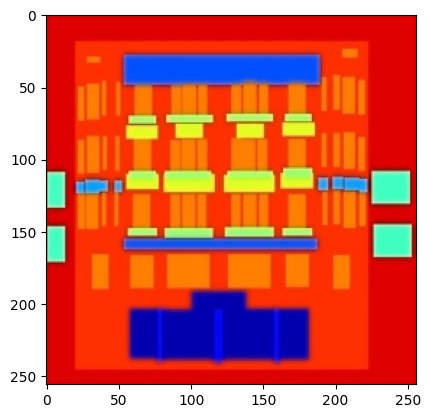

In [54]:
[X1, X2] = load_data()
ix = randint(0, len(X2),1)
src_image, tar_image = X1[ix], X2[ix]
plt.imshow(src_image[0,:,:])

In [55]:
gen_image = model.predict(src_image)

1/1 [==============================] - 0s 89ms/step


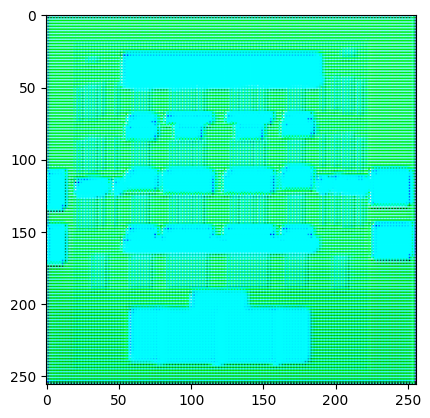

In [56]:
gen_image=gen_image[0,:,:]
gen_image = (gen_image + 1) / 2.0
plt.imshow(gen_image)

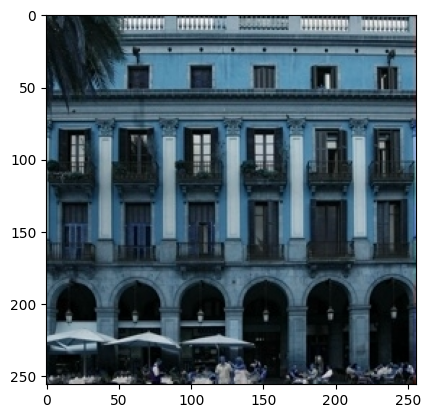

In [58]:
plt.imshow(tar_image[0,:,:])